# Goals of this notebook

- Closer look into the "Frame" interface
- User-facing data access tools

## Data access from the DataClass interface

In [1]:
from pathlib import Path
# Loading data from a list of paths

from SBART.data_objects import DataClassManager, DataClass
from SBART.Instruments import ESPRESSO
from SBART.outside_tools.create_logger import setup_SBART_logger

data_in_path = list(Path("/home/amiguel/phd/tools/sBART_private/tests/resources").iterdir())

instrument = ESPRESSO
inst_options = {"minimum_order_SNR" : 10,   # Minimum SNR to avoid discarding the spectral order (this is not used for S1D files)
                "spectra_format" : "S2D"  # S1D if we want to use those files; For the S2D mode we can use either S2D_A or S2D_BLAZE_A files
                }

log_storage_path = ""  # Root folder for the logger (path to that folder)
rv_method = ""         # Name of a folder created inside the root, e.g. log_storage_path/rv_method
write_to_file = False # if False, only prints to the terminal
setup_SBART_logger(log_storage_path, rv_method, instrument=instrument, write_to_file=False)
data = DataClass(data_in_path,
                 instrument=instrument,
                 instrument_options=inst_options,
                 storage_path=""
                 )


/home/amiguel/.virtualenvs/sbart-xwoIdkmx-py3.8/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/amiguel/.virtualenvs/sbart-xwoIdkmx-py3.8/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


2022-07-04T19:24:11 - SBART.outside_tools.create_logger - WARNING - Not storing logs to disk
2022-07-04T19:24:11 - SBART.utils.UserConfigs - DEBUG - Generating internal configs of  - 
2022-07-04T19:24:11 - SBART.utils.UserConfigs - INFO - Checking for any parameter that will take default value
2022-07-04T19:24:11 - SBART.data_objects.DataClass - INFO - DataClass opening 2 files from a list/tuple
2022-07-04T19:24:11 - SBART.utils.UserConfigs - DEBUG - Generating internal configs of Frame - ESPRESSO
2022-07-04T19:24:11 - SBART.utils.UserConfigs - DEBUG - Configuration <minimum_order_SNR> taking the value: 10
2022-07-04T19:24:11 - SBART.utils.UserConfigs - DEBUG - Configuration <spectra_format> taking the value: S2D
2022-07-04T19:24:11 - SBART.utils.UserConfigs - INFO - Checking for any parameter that will take default value
2022-07-04T19:24:11 - SBART.utils.UserConfigs - DEBUG - Configuration <bypass_QualCheck> using the default value: False
2022-07-04T19:24:11 - SBART.utils.UserConfigs 

## Handling the individual observations:

Each loaded observation (inside the DataClass) will have the following properties:

    - valid: True or False - can be triggered during data loading if QC flags are 'bad' or manually by the user
    - frameID: unique integer that is attributed to each observation (follows the order presented in the data_in_path file)

Independently of the chosen Instrument, there is a 'standard' name for quantities that are loaded from the header of the .fits file.
The full list of available header values is:
['BERV',
 'previousRV',
 'previousRV_ERR',
 'drift',
 'drift_ERR',
 'MAX_BERV',
 'relative_humidity',
 'ambient_temperature',
 'airmass',
 'orderwise_SNRs',
 'OBJECT',
 'BJD',
 'MJD',
 'DRS-VERSION',
 'MD5-CHECK',
 'ISO-DATE',
 'CONTRAST',
 'FWHM',
 'BIS SPAN',
 'RA',
 'DEC',
 'SPEC_TYPE']

Each KeyWord will have default value of NaN if a given instrument does not support it.
Some KeyWords are represented as SBART.utils.units values (i.e. meter_second or kilometer_second). Such keywords are:

['BERV',
 'previousRV',
 'previousRV_ERR',
 'drift',
 'drift_ERR',
 'MAX_BERV',
]
**Note**: Check the Frame.py file for a more up-to-date list

To access the individual observations we can either:
a) manually call for each frameID
b) Iterate over pre-built lists of frameIDs

In [5]:
# Get the OBS with an ID of zero
frame = data.get_frame_by_ID(frameID=0)

# To iterate over all frameIDs of all subInstruments
for subInstrument in data.get_subInstruments_with_valid_frames():
    # By default we are only interested in using the observations that are marked as "valid".
    # If we do want all of them, we can pass include_invalid = True
    for frameID in data.get_frameIDs_from_subInst(subInstrument, include_invalid=False):
        frame = data.get_frame_by_ID(frameID)
        print("{} :: ID = {}".format(subInstrument, frameID))

ESPRESSO18 :: ID = 0
ESPRESSO18 :: ID = 1
ESPRESSO18 :: ID = 2


## Access the keywords:

In [8]:
# From all frames of a given subInstrument:

all_measurements = data.collect_KW_observations(KW = "airmass",
                                                subInstruments=["ESPRESSO18"], # add other subInstruments to the list to also collect the keyword from them
                                                include_invalid=False
                                            )
print(all_measurements)

# from a given frame

single_measure = data.get_KW_from_frameID(KW = "airmass", frameID=0)
print(single_measure)

[1.32, 1.944, 1.321]
1.32


## Dealing with the SBART.utils.units

In [16]:
from SBART.utils.units import meter_second, kilometer_second, convert_data
BERV_values = all_measurements = data.collect_KW_observations(KW='BERV',
                                                              subInstruments=["ESPRESSO18"]
                                                            )
print("BERV_values: {}".format(BERV_values))
print("Converted BERV: {}".format(convert_data(BERV_values, new_units=kilometer_second, as_value=True)))
print("Converted BERV: {}".format(convert_data(BERV_values, new_units=meter_second, as_value=True)))

BERV_values: [<Quantity 21.25864312 km / s>, <Quantity 21.56800565 km / s>, <Quantity 21.45014697 km / s>]
Converted BERV: [21.2586431189802, 21.5680056474341, 21.4501469690604]
Converted BERV: [21258.6431189802, 21568.0056474341, 21450.1469690604]


## Properties from the frames:

In [9]:
filename = data.get_filename_from_frameID(frameID=0, full_path=False)
file_path = data.get_filename_from_frameID(frameID=0, full_path=True)

print("Filename is: {}".format(filename))
print("File path is: {}".format(file_path))

Filename is: r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits
File path is: /home/amiguel/seminar/test_new_version/dataset/r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits


## Access the spectral data from the frames:

- Option A) Using the DataClass interface
- Option B) Directly using the frame


The data is always returned in the following format:
- Wavelengths
- Fluxes
- Uncertainties
- Binary mask (1 in places of "bad" pixels)

**Note**: this bad pixel mask will contain the rejected regions from the Telluric Template and the Activity Indicators (if they are passed to the dataClass -  check data_interface notebook to see how)

The spectral orders can also be flagged as "invalid", due to:
    - Low SNR
    - Large percentage of the order being flagged (by default, > 75%)

If we request data from one of the "invalid" orders, it will raise an error, unless the "include_invalid=True") is passed as argument


2021-12-03T14:21:24 - SBART.Base_Models.Frame - INFO -Serving data from: r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits


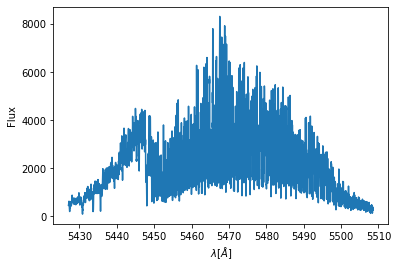

In [13]:
# Option A:

# Get the data from all spectral orders:
wavelength, fluxes, uncertainties, bad_pixel_location = data.get_frame_arrays_by_ID(frameID=0)

for order in range(data.get_instrument_information()["array_size"][0]):
    # Inverting the bad pixel mask, to have the "valid locations"
    valid_pixel_order = ~bad_pixel_location[order]

    clean_wave = wavelength[order][valid_pixel_order]
    clean_flux = fluxes[order][valid_pixel_order]
    clean_uncertainties = fluxes[order][valid_pixel_order]

order_wavelength, order_fluxes, order_uncertainties, bad_pixel_location = data.get_frame_OBS_order(frameID=0, order = 100,  include_invalid=False)

import matplotlib.pyplot as plt
plt.plot(order_wavelength[~bad_pixel_location], order_fluxes[~bad_pixel_location])
plt.xlabel(r"$\lambda [\AA]$")
plt.ylabel("Flux")
plt.show()

In [19]:

# Option B) Load a single frame:

frame = ESPRESSO(file_path="/home/amiguel/seminar/test_new_version/dataset/r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits")

BERV = frame.get_KW_value(KW = "BERV")

# all spectral orders
wavelength, fluxes, uncertainties, bad_pixel_location = frame.get_OBS_arrays()

# Single spectral order
wavelength, fluxes, uncertainties, bad_pixel_location = frame.get_OBS_order(order = 100, include_invalid=True)


2021-12-03T15:12:03 - SBART.Base_Models.Frame - INFO -Creating frame from: /home/amiguel/seminar/test_new_version/dataset/r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits
2021-12-03T15:12:03 - SBART.Base_Models.Frame - DEBUG -Validating header KeyWords
2021-12-03T15:12:03 - SBART.Instruments.ESPRESSO - INFO -Found 0 warning flags in the header KWs
2021-12-03T15:12:03 - SBART.Base_Models.Frame - INFO -Frame determined to be from ESPRESSO18
2021-12-03T15:12:03 - SBART.Base_Models.Frame - INFO -Serving data from: r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits
2021-12-03T15:12:03 - SBART.Base_Models.Frame - DEBUG -Opening the S2D arrays from r.ESPRE.2019-02-10T08:25:37.895_S2D_BLAZE_A.fits
2021-12-03T15:12:03 - SBART.Instruments.ESPRESSO - WARNING -Not applying correction to blue-red flux balance!
2021-12-03T15:12:03 - SBART.Base_Models.Frame - DEBUG -Creating spectral mask
2021-12-03T15:12:03 - SBART.Base_Models.Frame - INFO -Frame rejected 0 orders due to they only having less than 0.2